In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
!pip install darts
from darts import TimeSeries
from darts.metrics import mae, rmse
from darts.ad import ForecastingAnomalyModel, KMeansScorer, NormScorer
from darts.models import TCNModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping
from darts.utils.statistics import check_seasonality
from darts.metrics import mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from torch.optim import Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 804.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [34]:
df_train = pd.read_csv("/content/ECG5000_TRAIN.txt", delimiter='\s+', header=None)
df_test = pd.read_csv("/content/ECG5000_TEST.txt", delimiter='\s+', header=None)

df = pd.concat([df_train, df_test], ignore_index=True)
df.to_csv('Combined_data.csv', index=False, header=False)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


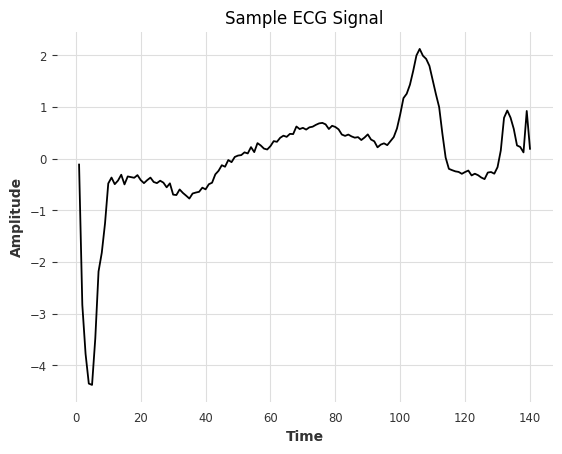

In [4]:
plt.plot(df.iloc[0, 1:])
plt.title("Sample ECG Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [45]:
CLASS_NORMAL = 1
class_names = ['Normal' , 'Anomaly1', 'Anomaly2', 'Anomaly3', 'Anomaly4']
new_columns = list(df.columns)
new_columns[0] = 'Class'
df.columns = new_columns
df.head()

,Class,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


In [46]:
df.Class.value_counts()

#number of counts of each kind of class in our data


,count
Class,
1.0,2919
2.0,1767
4.0,194
3.0,96
5.0,24


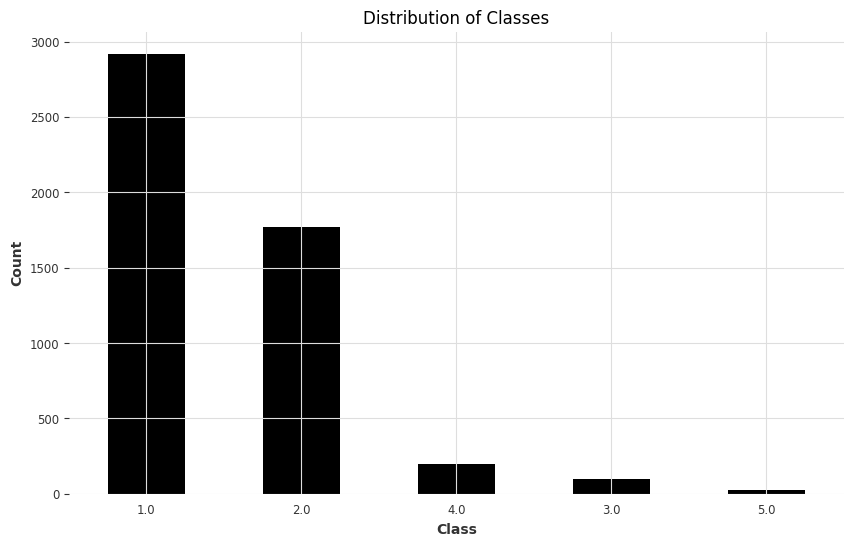

In [37]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.Class.value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

   Class         1         2         3         4         5         6  \
0    1.0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986   
1    1.0 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368   
2    1.0 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462   
3    1.0  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110   
4    1.0  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422   

          7         8         9  ...       131       132       133       134  \
0 -2.181408 -1.818286 -1.250522  ...  0.160348  0.792168  0.933541  0.796958   
1 -1.566126 -0.992258 -0.754680  ...  0.560327  0.538356  0.656881  0.787490   
2 -1.742940 -1.490659 -1.183580  ...  1.284825  0.886073  0.531452  0.311377   
3 -2.993280 -1.671131 -1.333884  ...  0.491173  0.350816  0.499111  0.600345   
4 -2.534510 -1.783423 -1.594450  ...  0.966606  1.148884  0.958434  1.059025   

        135       136       137       138       139       140  
0  0.578621  0.257740 

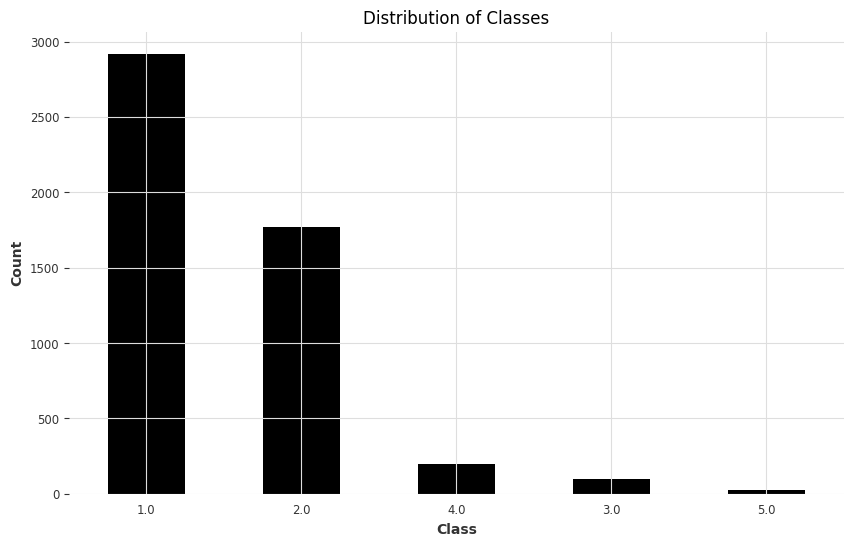

In [52]:
# Renaming the first column to 'Class'
df.columns = ['Class'] + list(df.columns[1:])

# Check the DataFrame to ensure renaming was successful
print(df.head())

# Plotting the distribution of classes
plt.figure(figsize=(10, 6))
df['Class'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Separate normal and abnormal data
normal_data = df[df['Class'] == CLASS_NORMAL]
abnormal_data = df[df['Class'] != CLASS_NORMAL]

In [53]:

normal_data = df.loc[df['Class'] == CLASS_NORMAL]#.drop(0, axis=1)
abnormal_data = df.loc[df['Class'] != CLASS_NORMAL]#.drop(0, axis=1)
normal_data.to_csv('normal data.csv', index=False)
abnormal_data.to_csv('abnormal data.csv', index=False)

In [6]:
normal_data.drop(normal_data.columns[0], axis=1, inplace=True)
abnormal_data.drop(abnormal_data.columns[0], axis=1, inplace=True)

<ipython-input-6-3e4a4277c637>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_data.drop(normal_data.columns[0], axis=1, inplace=True)
<ipython-input-6-3e4a4277c637>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal_data.drop(abnormal_data.columns[0], axis=1, inplace=True)


In [54]:
normal_data.head()

,Class,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


In [55]:
abnormal_data.head()

,Class,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
292,2.0,-0.032245,-0.545050,-0.822340,-1.605085,-1.805775,-2.008067,-2.233975,-2.191458,-2.058071,...,-0.906425,-1.621376,-2.329090,-3.049894,-3.620413,-4.210482,-4.043785,-3.051813,-2.806866,-0.879666
293,2.0,-0.003377,-0.279265,-0.230519,-0.635978,-0.894795,-1.023105,-1.243738,-1.458372,-1.677896,...,-2.155969,-2.640508,-3.218384,-3.651630,-3.881198,-3.924672,-3.164390,-2.228373,-1.837544,-0.378489
294,2.0,0.195989,-0.222258,-0.754773,-1.415614,-1.775851,-2.162326,-2.467492,-2.331384,-1.993476,...,-0.162438,-0.935030,-1.654340,-2.434240,-3.472170,-4.280780,-4.629438,-3.794192,-2.851468,-1.743521
295,2.0,0.894867,-0.003822,-0.751052,-1.396543,-1.737838,-2.113020,-2.213210,-2.203347,-2.024191,...,-0.899746,-1.441516,-1.861612,-2.321381,-2.884877,-3.530246,-4.412515,-3.903331,-3.567106,-1.536338
296,2.0,1.250060,0.760800,0.042925,-0.627974,-0.963454,-1.261335,-1.652440,-1.888433,-1.935217,...,-0.695282,-0.979223,-1.353969,-1.952051,-2.640386,-3.000281,-3.812490,-3.973360,-5.221946,-3.661793


In [56]:
# Split into training and test + validation
train_data, temp_data = train_test_split(normal_data, test_size=0.3, random_state=42)

# Split the remaining data into test and validation
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (2043, 141)
Validation Data Shape: (438, 141)
Test Data Shape: (438, 141)


In [58]:
# Convert all column names to strings
train_data.columns = train_data.columns.astype(str)
val_data.columns = val_data.columns.astype(str)
test_data.columns = test_data.columns.astype(str)

# Initialize RobustScaler
scaler = RobustScaler()

# Fit on training data and transform train, validation, and test sets
train_features_scaled = scaler.fit_transform(train_data)
val_features_scaled = scaler.transform(val_data)
test_features_scaled = scaler.transform(test_data)

# Convert scaled features back to DataFrames if needed
train_data_scaled = pd.DataFrame(train_features_scaled, columns=train_data.columns)
val_data_scaled = pd.DataFrame(val_features_scaled, columns=val_data.columns)
test_data_scaled = pd.DataFrame(test_features_scaled, columns=test_data.columns)

In [59]:
# Remove index

train_data_scaled.reset_index(drop=True, inplace=True)
val_data_scaled.reset_index(drop=True, inplace=True)
test_data_scaled.reset_index(drop=True, inplace=True)
train_data_scaled.head()

,Class,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,0.0,0.839248,1.292283,0.987485,0.058345,-0.582377,-0.373762,-0.449916,-0.664856,-0.589748,...,-0.265375,-0.391869,0.341800,0.030879,-0.143932,-0.335826,-0.122299,0.254380,0.024934,-0.256850
1,0.0,-0.275807,-0.535190,-0.549554,-0.174845,0.699793,0.944599,0.479219,0.247840,1.102784,...,-0.242300,0.568572,0.447589,0.200100,0.281066,0.235796,0.120509,-0.021199,0.342718,0.782722
2,0.0,2.236716,2.393658,2.049168,2.304653,0.539377,-0.421353,-0.344713,1.040576,-0.010265,...,-3.617046,-4.518786,-3.326732,-2.212527,-1.306004,-0.521562,-0.267923,-0.314913,-0.710822,0.346269
3,0.0,1.476550,1.260409,0.854183,0.796802,-1.817792,-1.646699,-1.127945,-0.656004,-0.450035,...,-1.802146,-1.332376,0.113713,-0.013878,0.549608,0.718334,0.726344,0.189126,-0.472769,0.592118
4,0.0,1.277607,1.551714,2.403606,4.610046,5.983843,3.247492,2.489437,5.856462,3.375615,...,-2.107139,-2.921694,-2.676259,-2.022617,-1.537035,-1.412944,-1.248509,-1.059544,-0.997188,-0.777456


In [60]:
#%% Printing infos
train_data_scaled.info()
val_data_scaled.info()
test_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Columns: 141 entries, Class to 140
dtypes: float64(141)
memory usage: 2.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 141 entries, Class to 140
dtypes: float64(141)
memory usage: 482.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Columns: 141 entries, Class to 140
dtypes: float64(141)
memory usage: 482.6 KB


In [61]:
train_series = TimeSeries.from_dataframe(train_data_scaled)
val_series = TimeSeries.from_dataframe(val_data_scaled)
test_series = TimeSeries.from_dataframe(test_data_scaled)
train_series = train_series.astype(np.float32)
val_series = val_series.astype(np.float32)
test_series = test_series.astype(np.float32)

In [62]:

# Define the model
ecg_model = TCNModel(
    input_chunk_length=50,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=32,
    num_layers=3,
    dropout=0.2,
    optimizer_cls=Adam,
    optimizer_kwargs={"lr": 0.001},
    random_state=42
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=10,          # Number of epochs to wait for improvement
    mode="max"           # Mode should be 'min' for loss metrics
)

# Initialize the trainer with callbacks
trainer = Trainer(
    callbacks=[early_stopping_callback],
    max_epochs=10,
    logger=True,
    enable_progress_bar=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [63]:
ecg_model.fit(train_series, val_series=val_series, trainer=trainer)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 48.9 K | train
-------------------------------------------------------------
48.9 K    Trainable params
0         Non-trainable params
48.9 K    Total params
0.195     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=32, num_layers=3, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=50, output_chunk_length=30, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, random_state=42)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

On testing set -> MAE: 0.8089113831520081, RMSE: 1.122633457183838


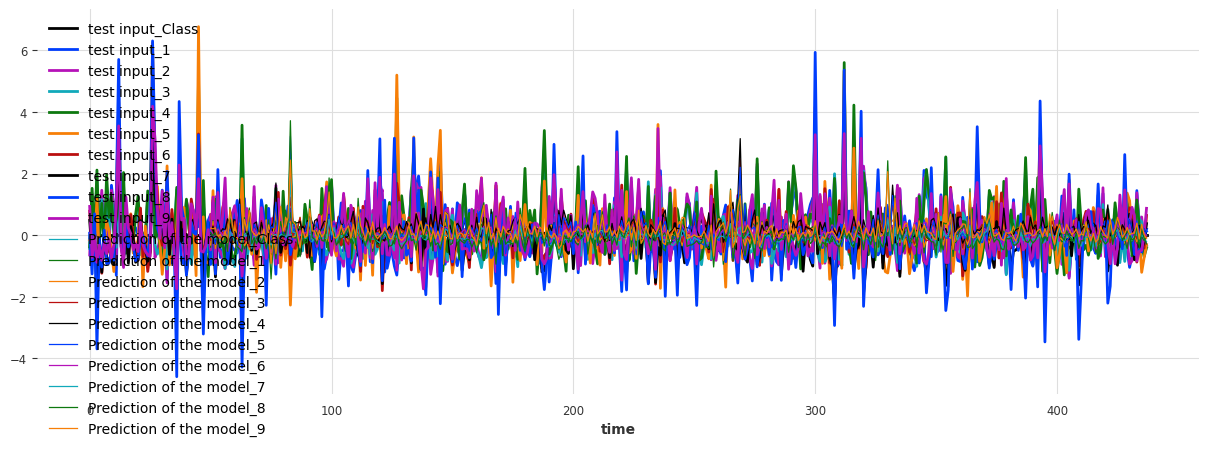

In [65]:
# Convert all column names to strings
abnormal_data.columns = abnormal_data.columns.astype(str)

abnormal_features_scaled = scaler.transform(abnormal_data)
abnormal_data_scaled = pd.DataFrame(abnormal_features_scaled, columns=test_data.columns)

abnormal_series = TimeSeries.from_dataframe(abnormal_data_scaled)
abnormal_series = abnormal_series.astype(np.float32)


# instantiate the anomaly model with: one fitted model, and 3 scorers
anomaly_model = ForecastingAnomalyModel(
    model=ecg_model,
    scorer=[
        NormScorer(ord=1),
    ],
)


START = 0.1
anomaly_model.fit(train_series, start=START, allow_model_training=False, verbose=True, scorer=NormScorer)

anomaly_scores, model_forecasting = anomaly_model.score(
    test_series, start=START, return_model_prediction=True, verbose=True
)
pred_start = model_forecasting.start_time()

print(
    "On testing set -> MAE: {}, RMSE: {}".format(
        mae(model_forecasting, test_series), rmse(model_forecasting, test_series)
    )
)

# plot the data and the anomalies
fig, ax = plt.subplots(figsize=(15, 5))
test_series.plot(label="test input")
model_forecasting.plot(label="Prediction of the model", linewidth=0.9)
plt.show()